In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import snow.utils as sf
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

In [2]:
raw_financials = sf.from_snow(role='all_data_viewer',wh='load_wh',db='all_data',q_kind='financials',to_df=False)
raw_financials = raw_financials[2:]

INFO:snowflake.connector.connection:Snowflake Connector for Python Version: 1.7.8, Python Version: 3.7.2, Platform: Darwin-18.2.0-x86_64-i386-64bit
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): livenpay.ap-southeast-2.snowflakecomputing.com
INFO:snowflake.connector.cursor:query: [use warehouse load_wh]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.cursor:query: [use all_data.postgres]


Using all_data_viewer...
Established connection.


INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.cursor:query: [SELECT TO_CHAR(TO_DATE(CONVERT_TIMEZONE('UTC', 'Australia/Sydney', CAST(accountc...]


Querying load_wh.all_data.postgres


INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.cursor:fetching data done
INFO:snowflake.connector.connection:closed


Financials data:  (None, 0.0, 0.0, 0.0, 0.0, 0) 

Connection succesfully closed.


In [3]:
financials_df = pd.DataFrame(raw_financials
            ,columns=['ds','Gross revenue','Org. volume','Total volume','Org. count','Total count'])

In [4]:
financials_df.head()

,ds,Gross revenue,Org. volume,Total volume,Org. count,Total count
0,2019-05-24,7374.5660,48448.496,53253.39,2372.0,2993
1,2019-05-23,5556.7795,35555.277,39608.01,1848.0,2424
2,2019-05-22,4430.1160,28505.358,31826.00,1768.0,2219
3,2019-05-21,4411.7930,29304.015,32610.72,1747.0,2167
4,2019-05-20,3442.6605,26161.190,28468.92,1723.0,1959


In [39]:
total_volume_df = financials_df
total_volume_df = total_volume_df.drop(['Total volume','Gross revenue','Org. count','Total count'],axis=1)

In [40]:
total_volume_df.rename(index=str, columns={"Org. volume":"y"},inplace=True)
total_volume_df.sort_values(by='ds',ascending=False)

## Below line reverses the ordering of the dataframe
total_volume_df = total_volume_df.iloc[::-1]

In [428]:
sf.from_snow(schema='forecasts',query='select * from organic_volume_',to_df=False)[:3]

INFO:snowflake.connector.connection:Snowflake Connector for Python Version: 1.7.8, Python Version: 3.7.2, Platform: Darwin-18.2.0-x86_64-i386-64bit
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): livenpay.ap-southeast-2.snowflakecomputing.com
INFO:snowflake.connector.cursor:query: [use warehouse zans_wh]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.cursor:query: [use zans_db.forecasts]


Using zans_role...
Established connection.


INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.cursor:query: [select * from organic_volume_]


Querying zans_wh.zans_db.forecasts


INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.cursor:fetching data done
INFO:snowflake.connector.connection:closed


Custom data:  ('2017-11-23 00:00:00', 1622.911364758, -1378.641256406, 4483.117441784, 281.802628457, 421.116531665, 154.21588613) 

Connection succesfully closed.


[('2017-11-23 00:00:00',
  1622.911364758,
  -1378.641256406,
  4483.117441784,
  281.802628457,
  421.116531665,
  154.21588613),
 ('2017-11-24 00:00:00',
  2001.048308242,
  -713.372521377,
  4809.626999929,
  281.378082366,
  414.694597336,
  161.453866859),
 ('2017-11-25 00:00:00',
  1805.315568031,
  -963.162172548,
  4704.676422079,
  280.953536274,
  410.603484812,
  165.498346526)]

In [400]:
# 13.5 MAPE model
model = Prophet(seasonality_mode='multiplicative'
            ,growth='linear'
            ,daily_seasonality=False
            ,weekly_seasonality=False
            ,yearly_seasonality=False
            ,mcmc_samples=100
            ,interval_width=0.9
           ).add_seasonality(name='weekly',period=7,fourier_order=20,prior_scale=30)
model.fit(total_volume_df.tail(548))

In [415]:
future = model.make_future_dataframe(periods=91)
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2017-11-23,281.802628,-1378.641256,4483.117442,154.215886,421.116532,4.759036,3.716191,5.922677,4.759036,3.716191,5.922677,0.0,0.0,0.0,1622.911365
1,2017-11-24,281.378082,-713.372521,4809.627000,161.453867,414.694597,6.111600,4.815438,7.547652,6.111600,4.815438,7.547652,0.0,0.0,0.0,2001.048308
2,2017-11-25,280.953536,-963.162173,4704.676422,165.498347,410.603485,5.425673,4.257505,6.765891,5.425673,4.257505,6.765891,0.0,0.0,0.0,1805.315568
3,2017-11-26,280.528990,-1156.531639,4394.064825,169.215576,405.488200,4.885128,3.824037,6.049304,4.885128,3.824037,6.049304,0.0,0.0,0.0,1650.948947
4,2017-11-27,280.104444,-1525.222038,4057.766930,171.372918,401.202153,3.593981,2.773760,4.502098,3.593981,2.773760,4.502098,0.0,0.0,0.0,1286.794600


In [425]:
df = forecast[['ds','yhat','yhat_lower','yhat_upper','trend','trend_upper','trend_lower']]
df.ds = df.ds.apply(lambda x:str(x))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [426]:
df.tail()

,ds,yhat,yhat_lower,yhat_upper,trend,trend_upper,trend_lower
634,2019-08-19 00:00:00,45827.632202,36655.261806,53310.879881,9975.580747,12717.742844,7585.915019
635,2019-08-20 00:00:00,48696.457219,38995.367849,56523.208759,10012.916179,12761.225793,7585.983816
636,2019-08-21 00:00:00,51842.763026,41791.294940,60350.361540,10050.251611,12830.105988,7602.559802
637,2019-08-22 00:00:00,58094.772729,46472.043627,67894.912853,10087.587043,12906.826742,7605.059641
638,2019-08-23 00:00:00,72004.396429,57775.803290,83515.137258,10124.922475,12979.322123,7595.407508


In [427]:
from datetime import datetime

date = str(datetime.now().date())

sf.to_snow(df=df,schema='forecasts',table='organic_volume')

INFO:snowflake.connector.connection:Snowflake Connector for Python Version: 1.7.8, Python Version: 3.7.2, Platform: Darwin-18.2.0-x86_64-i386-64bit
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): livenpay.ap-southeast-2.snowflakecomputing.com


2019-05-25
Accepted dataframe object


INFO:snowflake.connector.cursor:query: [SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.cursor:query: [SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.cursor:query: [ROLLBACK]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.cursor:query: [use warehouse zans_wh]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.cursor:query: [create schema zans_db.forecasts]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.cursor:query: [ROLLBACK]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.cursor:query: [use zans_db.forecasts]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.cursor:query: [DESC TABLE /* sqlalchemy:_has_object */ organic_volume_]


Schema: forecasts already exists; updating organic_volume table.


INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.cursor:query: [DESC TABLE /* sqlalchemy:_has_object */ organic_volume_]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.cursor:query: [SHOW /* sqlalchemy:get_table_names */ TABLES]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.cursor:fetching data done
INFO:snowflake.connector.cursor:query: [DESCRIBE TABLE /* sqlalchemy:get_primary_keys */ forecasts.organic_volume_]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.cursor:fetching data done
INFO:snowflake.connector.cursor:query: [SELECT /* sqlalchemy:get_columns */ ic.table_name, ic.column_name, ic.data_type,...]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.cursor:fetching data done
INFO:snowflake.connector.cursor:query: [SHOW /* sqlalchemy:get_foreign_keys */ IMPORTED KEYS IN SCHEMA zans_db.forecasts...]
INFO:snowflake.connector.cursor:q

organic_volume successfully updated.
Engine successfully closed


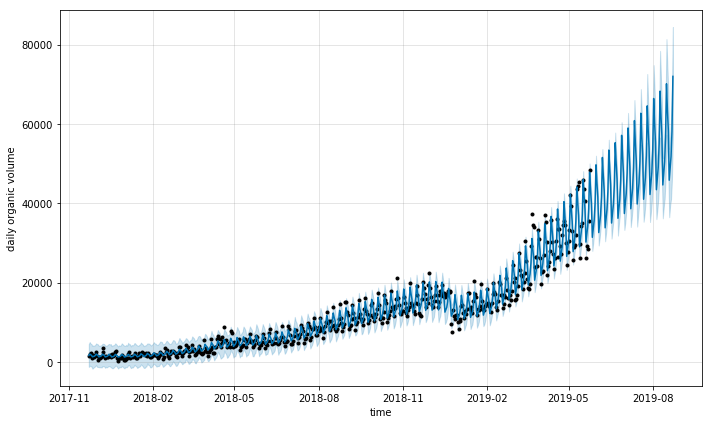

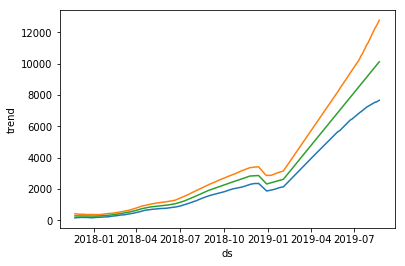

In [410]:
import matplotlib.pyplot as plt
import seaborn as sns

fig1 = model.plot(forecast,ylabel='daily organic volume',xlabel='time')
plt.show()
sns.lineplot(data=forecast,x='ds',y='trend_lower')
sns.lineplot(data=forecast,x='ds',y='trend_upper')
sns.lineplot(data=forecast,x='ds',y='trend')

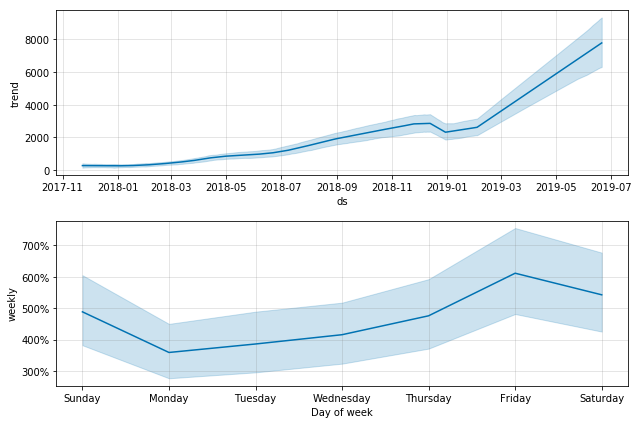

In [405]:
fig = model.plot_components(forecast)

In [338]:
import matplotlib.pyplot as plt
import seaborn as sns

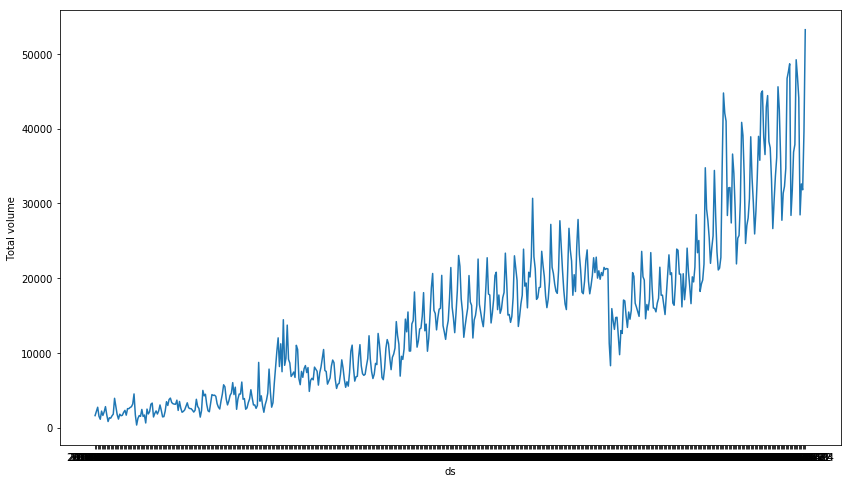

In [339]:
plt.figure(figsize=(14,8))
sns.lineplot(data=financials_df.head(548),x='ds',y='Total volume')
plt.show()

https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html

Take in dataset, apply log transformation and forecast on that. Coax the data to make it more stationary like. Apply log transformation, predict the log, and then the transform the prediciton.



Another transformation is differencing. Take value of the difference between the 1st and 2nd points, then the 2nd and 3rd, and so on...


Explore whether the variants of the dataset are heteroskedastic -- i.e. is there a trend where variance , not just the y value, is growing or not.

Many models assume constant variance, so we need to adjust for multiplicate seasonal changes (i.e. multipled by a scalar value as opposed to just adding a constant bias factor) if the seasonal variance itself is growing. 

#### Augmented Dickey-Fuller test: what is the stationariy is the data set?

In [325]:
import statsmodels.api as sm
import statsmodels.formula.api as sm
from statsmodels.tsa.stattools import adfuller

In [326]:
adfuller(x=financials_df['Org. volume'].values)

(-6.685169552684,
 4.244046371302285e-09,
 25,
 1749,
 {'1%': -3.4340943816187823,
  '5%': -2.8631939359068803,
  '10%': -2.5676505066098376},
 28746.297027397668)

###### Holy shit! Our dataset is actually highly stationary

### How can we measure the performance of our model?

In [327]:
def MAPE(y_true, y_pred):
    'Ingest true and predicted values, output Mean abolute percentage error score.'
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [406]:
cv_results = cross_validation(model, initial='112 days', period='56 days', horizon='28 days')
mape_baseline = MAPE(cv_results.y, cv_results.yhat)
mape_baseline

INFO:fbprophet:Making 8 forecasts with cutoffs between 2018-03-30 00:00:00 and 2019-04-26 00:00:00


13.687228083333643

### Can we use one time series to predict the values of another?

##### Let's try using multivariate autoregressive models

https://en.wikipedia.org/wiki/Vector_autoregression

#### How do we test for one values predictive power over another?

https://en.wikipedia.org/wiki/Granger_causality
    
https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.grangercausalitytests.html
    
Here, the first column is the dependent variable you want to predict and the second column is the variable you think can help predict the first variable. 

If p-value less than 0.05 (so significant), then the feature you are looking at DOES help to predict the variable

#### How many steps in advance is the 'cause' time-series most predictive of the 'effect' time-series?

How do we select for the ideal time-step? And by extension, optimize/select for the best model? The AIC test.

https://en.wikipedia.org/wiki/Akaike_information_criterion

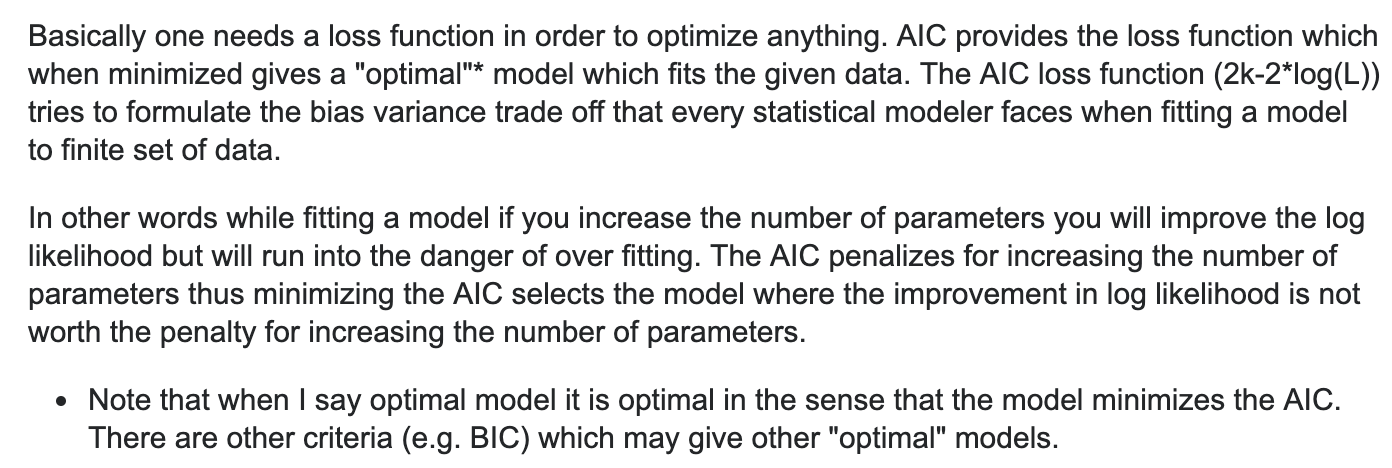

In [65]:
from IPython.display import Image
Image("AIC intuition.png")